# MovieLens 20M EDA (with Genome features) — Binary Like/Dislike

This notebook implements a practical EDA workflow for a recommendation setting using the following files:

- `rating.csv` (userId, movieId, rating, timestamp)  
- `movie.csv` (movieId, title, genres)  
- `tag.csv` (userId, movieId, tag, timestamp)  
- `link.csv` (movieId, imdbId, tmdbId)  
- `genome_tags.csv` (tagId, tag)  
- `genome_scores.csv` (movieId, tagId, relevance)

The goal is to understand distributions, sparsity, long-tail effects, temporal behavior, and the potential value of content features (`genres`, user `tags`, and `genome_scores`) before modeling a binary target (like/dislike).

## Contents
1. Setup and data loading  
2. Sanity checks and coverage across tables  
3. Rating distribution and binarization (`like = rating >= 4.0`)  
4. User-level behavior (activity and rating bias)  
5. Movie-level behavior (popularity, mean rating)  
6. Genres exploration  
7. Sparsity diagnostics and interaction matrix sampling  
8. Popularity vs. mean rating diagnostics  
9. Temporal analysis (volume and preferences over time)  
10. User tags exploration (`tag.csv`)  
11. Genome features exploration (`genome_scores.csv`, `genome_tags.csv`)  
12. Links coverage (`link.csv`)  
13. Cleaning checks and outlier patterns  

Notes:
- MovieLens 20M is large; use Parquet and/or sampling if memory becomes a bottleneck.
- Visualizations use Matplotlib only (no seaborn) to minimize dependencies.


In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_DIR = Path("../data/raw/movielens-20m-dataset/")  

## 1) Load data

This loader expects the following exact filenames:
- `rating.csv`, `movie.csv`, `tag.csv`, `link.csv`, `genome_tags.csv`, `genome_scores.csv`

If your dataset uses different names (e.g., `ratings.csv`, `movies.csv`, `tags.csv`, `links.csv`), rename the files or adjust the paths below.


In [7]:
paths = {
    "ratings": DATA_DIR / "rating.csv",
    "movies": DATA_DIR / "movie.csv",
    "tags": DATA_DIR / "tag.csv",
    "links": DATA_DIR / "link.csv",
    "genome_tags": DATA_DIR / "genome_tags.csv",
    "genome_scores": DATA_DIR / "genome_scores.csv",
}

for k, p in paths.items():
    if not p.exists():
        raise FileNotFoundError(f"Missing file for {k}: {p}")
    else:
        print(k, "check")

ratings check
movies check
tags check
links check
genome_tags check
genome_scores check


In [27]:
ratings_dtypes = {"userId": "int32", "movieId": "int32", "rating": "float32", "timestamp": "string"}
movies_dtypes = {"movieId": "int32", "title": "string", "genres": "string"}
tags_dtypes = {"userId": "int32", "movieId": "int32", "tag": "string", "timestamp": "string"}
links_dtypes = {"movieId": "int32", "imdbId": "Int64", "tmdbId": "Int64"}  # nullable ints
g_tags_dtypes = {"tagId": "int32", "tag": "string"}
g_scores_dtypes = {"movieId": "int32", "tagId": "int32", "relevance": "float32"}

ratings = pd.read_csv(paths["ratings"], dtype=ratings_dtypes)
movies = pd.read_csv(paths["movies"], dtype=movies_dtypes)
tags = pd.read_csv(paths["tags"], dtype=tags_dtypes)
links = pd.read_csv(paths["links"], dtype=links_dtypes)
genome_tags = pd.read_csv(paths["genome_tags"], dtype=g_tags_dtypes)
genome_scores = pd.read_csv(paths["genome_scores"], dtype=g_scores_dtypes)

ratings["timestamp"] = pd.to_datetime(ratings["timestamp"], format="%Y-%m-%d %H:%M:%S")
ratings["timestamp"] = ratings["timestamp"].dt.strftime("%d-%m-%Y")
ratings["timestamp_dt"] = pd.to_datetime(ratings["timestamp"], format="%d-%m-%Y")

tags["timestamp"] = pd.to_datetime(tags["timestamp"], format="%Y-%m-%d %H:%M:%S")
tags["timestamp"] = tags["timestamp"].dt.strftime("%d-%m-%Y")
tags["timestamp_dt"] = pd.to_datetime(tags["timestamp"], format="%d-%m-%Y")

print("ratings:", ratings.shape)
print("movies:", movies.shape)
print("tags:", tags.shape)
print("links:", links.shape)
print("genome_tags:", genome_tags.shape)
print("genome_scores:", genome_scores.shape)

ratings.head()

ratings: (20000263, 5)
movies: (27278, 3)
tags: (465564, 5)
links: (27278, 3)
genome_tags: (1128, 2)
genome_scores: (11709768, 3)


,userId,movieId,rating,timestamp,timestamp_dt
0,1,2,3.5,02-04-2005,2005-04-02
1,1,29,3.5,02-04-2005,2005-04-02
2,1,32,3.5,02-04-2005,2005-04-02
3,1,47,3.5,02-04-2005,2005-04-02
4,1,50,3.5,02-04-2005,2005-04-02


## 2) Sanity checks and table coverage

We check:
- missing values and duplicate keys
- how well keys align across tables (movieId coverage)
- basic uniqueness counts


In [28]:
def basic_checks(df: pd.DataFrame, name: str):
    print(f"\n{name}")
    print("  shape:", df.shape)
    print("  columns:", df.columns.tolist())
    print("  missing values:\n", df.isna().sum())
    print("  duplicated rows:", int(df.duplicated().sum()))

basic_checks(ratings, "ratings")
basic_checks(movies, "movies")
basic_checks(tags, "tags")
basic_checks(links, "links")
basic_checks(genome_tags, "genome_tags")
basic_checks(genome_scores, "genome_scores")

# Uniqueness
n_users = ratings["userId"].nunique()
n_movies_rated = ratings["movieId"].nunique()
n_movies_total = movies["movieId"].nunique()
print(f"\nUnique users in ratings: {n_users:,}")
print(f"Unique movies in ratings: {n_movies_rated:,}")
print(f"Total movies in movie.csv: {n_movies_total:,}")

# Coverage: rated movies present in movies table
rated_not_in_movies = set(ratings["movieId"].unique()) - set(movies["movieId"].unique())
print("Rated movies missing from movies table:", len(rated_not_in_movies))

# Coverage: genome coverage among rated movies
genome_movies = set(genome_scores["movieId"].unique())
rated_movies  = set(ratings["movieId"].unique())
genome_coverage = len(genome_movies & rated_movies) / len(rated_movies)
print(f"Genome coverage among rated movies: {genome_coverage:.3%}")

# Coverage: links coverage among rated movies
link_movies = set(links["movieId"].unique())
links_coverage = len(link_movies & rated_movies) / len(rated_movies)
print(f"Link coverage among rated movies: {links_coverage:.3%}")



ratings
  shape: (20000263, 5)
  columns: ['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt']
  missing values:
 userId          0
movieId         0
rating          0
timestamp       0
timestamp_dt    0
dtype: int64
  duplicated rows: 0

movies
  shape: (27278, 3)
  columns: ['movieId', 'title', 'genres']
  missing values:
 movieId    0
title      0
genres     0
dtype: int64
  duplicated rows: 0

tags
  shape: (465564, 5)
  columns: ['userId', 'movieId', 'tag', 'timestamp', 'timestamp_dt']
  missing values:
 userId           0
movieId          0
tag             16
timestamp        0
timestamp_dt     0
dtype: int64
  duplicated rows: 0

links
  shape: (27278, 3)
  columns: ['movieId', 'imdbId', 'tmdbId']
  missing values:
 movieId      0
imdbId       0
tmdbId     252
dtype: int64
  duplicated rows: 0

genome_tags
  shape: (1128, 2)
  columns: ['tagId', 'tag']
  missing values:
 tagId    0
tag      0
dtype: int64
  duplicated rows: 0

genome_scores
  shape: (11709768, 3)
  colu

## 3) Rating distribution and binarization

We binarize ratings into:
- `like = 1` if rating >= 4.0
- `like = 0` otherwise

This is a common, pragmatic threshold. You can later test alternative thresholds.


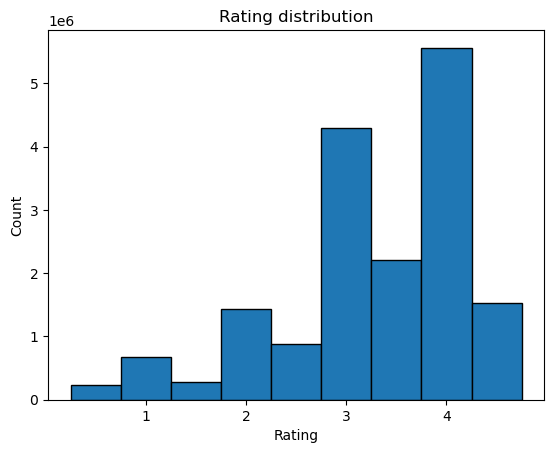

Like threshold: 4.0
Like rate: 0.4998


like
0    0.500236
1    0.499764
Name: proportion, dtype: float64

In [29]:
plt.figure()
plt.hist(ratings["rating"].values, bins=np.arange(0.25, 5.25, 0.5), edgecolor="black")
plt.title("Rating distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

LIKE_THRESHOLD = 4.0
ratings["like"] = (ratings["rating"] >= LIKE_THRESHOLD).astype("int8")

like_rate = ratings["like"].mean()
print(f"Like threshold: {LIKE_THRESHOLD}")
print(f"Like rate: {like_rate:.4f}")

ratings["like"].value_counts(normalize=True).rename("proportion")


## 4) User-level analysis

We evaluate:
- ratings per user (activity distribution)
- mean rating and like-rate per user (rating bias / generosity)
- prevalence of cold-start users


In [31]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'timestamp_dt', 'like'], dtype='str')

In [32]:
user_stats = (
    ratings.groupby("userId")
    .agg(
        n_ratings=("movieId", "size"),
        mean_rating=("rating", "mean"),
        like_rate=("like", "mean"),
        min_ts=("timestamp_dt", "min"),
        max_ts=("timestamp_dt", "max"),
    )
    .reset_index()
)

user_stats.describe(percentiles=[0.5, 0.9, 0.95, 0.99])


,userId,n_ratings,mean_rating,like_rate,min_ts,max_ts
count,138493.000000,138493.000000,138493.000000,138493.000000,138493,138493
mean,69247.000000,144.413530,3.627209,0.549342,2003-08-17 01:03:50.489627,2004-02-29 15:20:59.491815
min,1.000000,20.000000,0.500000,0.000000,1995-01-09 00:00:00,1996-02-23 00:00:00
50%,69247.000000,68.000000,3.653846,0.558140,2002-09-15 00:00:00,2003-07-07 00:00:00
90%,124643.800000,334.000000,4.156327,0.791667,2012-02-25 00:00:00,2013-02-02 00:00:00
95%,131568.400000,520.000000,4.290323,0.846154,2013-09-05 00:00:00,2014-06-05 09:35:59.999999
99%,137108.080000,1113.080000,4.541945,0.927273,2015-01-13 00:00:00,2015-03-15 00:00:00
max,138493.000000,9254.000000,5.000000,1.000000,2015-03-31 00:00:00,2015-03-31 00:00:00
std,39979.629753,230.267257,0.443030,0.188145,NaN,NaN


We know for a fact that all user have at least 20 reviews.
```
Users were selected at random for inclusion. All selected users had rated at least 20 movies.
```

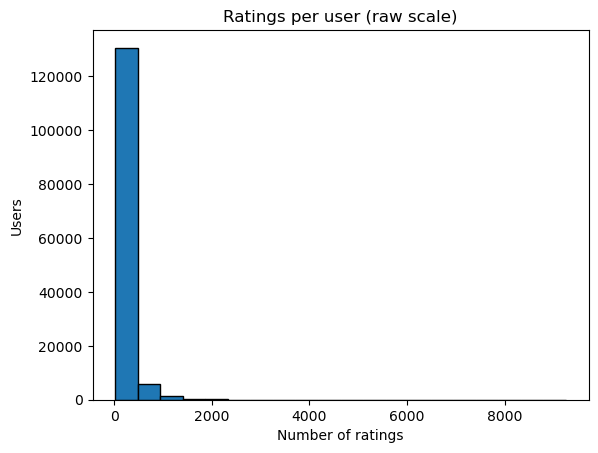

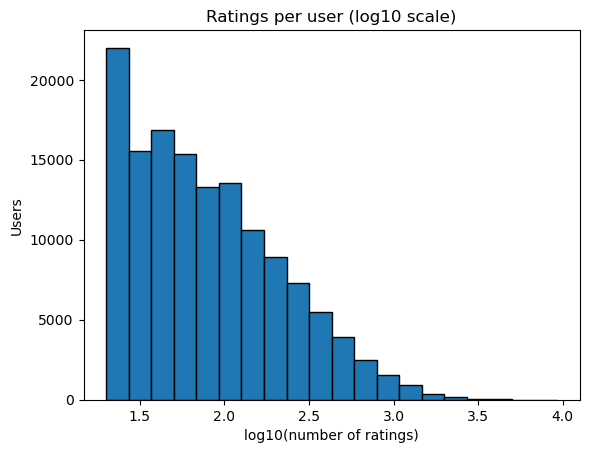

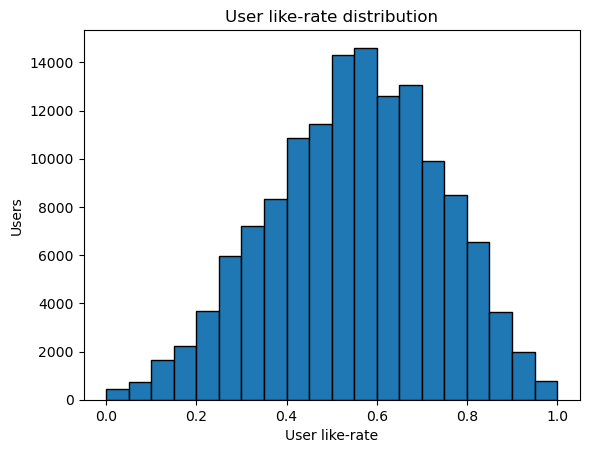

Users with < 30 ratings: 18.733%
Users with < 50 ratings: 38.403%
Users with < 100 ratings: 62.023%
Users with < 200 ratings: 80.630%
--------------------------------
count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: n_ratings, dtype: float64


In [38]:
plt.figure()
plt.hist(user_stats["n_ratings"].values, bins=20, edgecolor="black")
plt.title("Ratings per user (raw scale)")
plt.xlabel("Number of ratings")
plt.ylabel("Users")
plt.show()

plt.figure()
plt.hist(np.log10(user_stats["n_ratings"].values), bins=20, edgecolor="black")
plt.title("Ratings per user (log10 scale)")
plt.xlabel("log10(number of ratings)")
plt.ylabel("Users")
plt.show()

plt.figure()
plt.hist(user_stats["like_rate"].values, bins=20, edgecolor="black")
plt.title("User like-rate distribution")
plt.xlabel("User like-rate")
plt.ylabel("Users")
plt.show()

for k in [30, 50, 100, 200]:
    frac = (user_stats["n_ratings"] < k).mean()
    print(f"Users with < {k} ratings: {frac:.3%}")
print("--------------------------------")
print(user_stats["n_ratings"].describe())

## 5) Movie-level analysis

We evaluate:
- ratings per movie (popularity distribution)
- mean rating and like-rate per movie
- long-tail of items (cold-start movies)


In [39]:
movie_stats = (
    ratings.groupby("movieId")
    .agg(
        n_ratings=("userId", "size"),
        mean_rating=("rating", "mean"),
        like_rate=("like", "mean"),
    )
    .reset_index()
    .merge(movies, on="movieId", how="left")
)

movie_stats.describe(percentiles=[0.5, 0.9, 0.95, 0.99])


,movieId,n_ratings,mean_rating,like_rate
count,26744.000000,26744.000000,26744.000000,26744.000000
mean,58789.612436,747.841123,3.133200,0.312804
std,44159.344871,3085.818268,0.664084,0.259809
min,1.000000,1.000000,0.500000,0.000000
50%,65880.000000,18.000000,3.235294,0.287704
90%,114930.100000,1305.700000,3.848406,0.645948
95%,122691.500000,3612.950000,4.000000,0.755077
99%,129836.280000,14388.690000,4.500000,1.000000
max,131262.000000,67310.000000,5.000000,1.000000


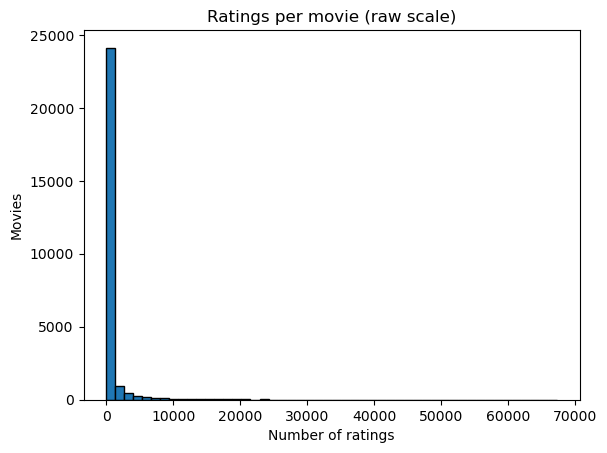

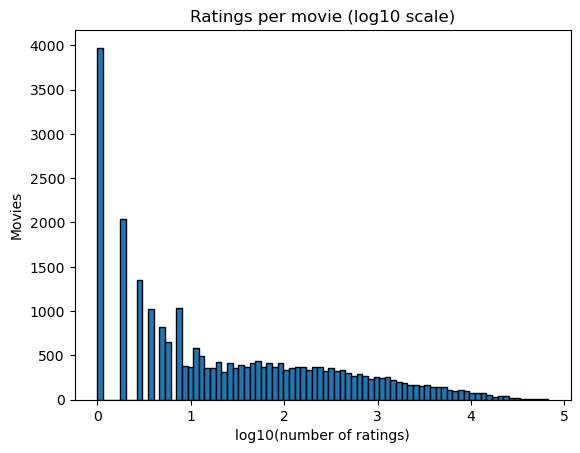

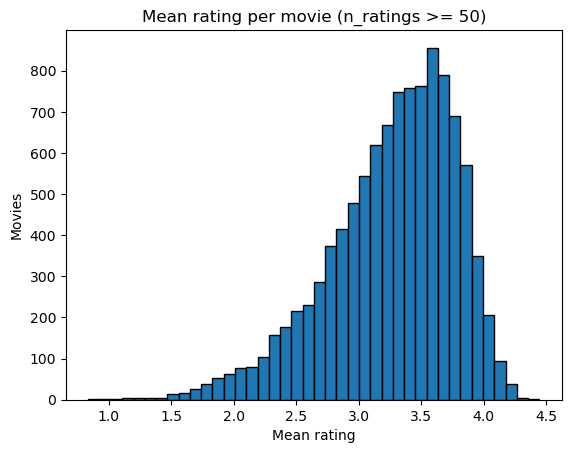

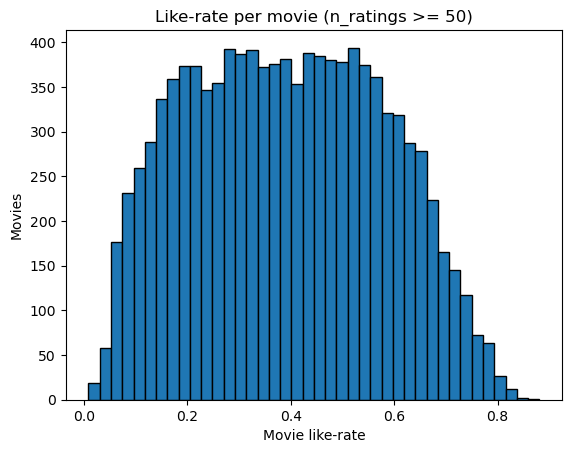

Movies with < 5 ratings: 31.405%
Movies with < 10 ratings: 42.226%
Movies with < 20 ratings: 50.897%
Movies with < 50 ratings: 60.649%


In [42]:
plt.figure()
plt.hist(movie_stats["n_ratings"].values, bins=50, edgecolor="black")
plt.title("Ratings per movie (raw scale)")
plt.xlabel("Number of ratings")
plt.ylabel("Movies")
plt.show()

plt.figure()
plt.hist(np.log10(movie_stats["n_ratings"].values), bins=80, edgecolor="black")
plt.title("Ratings per movie (log10 scale)")
plt.xlabel("log10(number of ratings)")
plt.ylabel("Movies")
plt.show()

MIN_RATINGS_FOR_MEAN = 50
subset = movie_stats[movie_stats["n_ratings"] >= MIN_RATINGS_FOR_MEAN]

plt.figure()
plt.hist(subset["mean_rating"].values, bins=40, edgecolor="black")
plt.title(f"Mean rating per movie (n_ratings >= {MIN_RATINGS_FOR_MEAN})")
plt.xlabel("Mean rating")
plt.ylabel("Movies")
plt.show()

plt.figure()
plt.hist(subset["like_rate"].values, bins=40, edgecolor="black")
plt.title(f"Like-rate per movie (n_ratings >= {MIN_RATINGS_FOR_MEAN})")
plt.xlabel("Movie like-rate")
plt.ylabel("Movies")
plt.show()

for k in [5, 10, 20, 50]:
    frac = (movie_stats["n_ratings"] < k).mean()
    print(f"Movies with < {k} ratings: {frac:.3%}")


## 6) Genres exploration

The `genres` column is pipe-delimited (e.g., `Action|Adventure|Sci-Fi`).
We compute:
- genre frequency (# movies)
- genre aggregates of popularity and mean ratings


In [43]:
movie_genres = movies.copy()
movie_genres["genres_list"] = movie_genres["genres"].fillna("(no genres listed)").str.split("|")

all_genres = movie_genres["genres_list"].explode()
genre_counts = all_genres.value_counts().to_frame("n_movies")
genre_counts.head(20)


,n_movies
genres_list,
Drama,13344
Comedy,8374
Thriller,4178
Romance,4127
Action,3520
Crime,2939
Horror,2611
Documentary,2471
Adventure,2329


In [44]:
mg = movie_stats[["movieId", "n_ratings", "mean_rating", "like_rate"]].merge(
    movie_genres[["movieId", "genres_list"]], on="movieId", how="left"
)
g_expl = mg.explode("genres_list").rename(columns={"genres_list": "genre"})

genre_agg = (
    g_expl.groupby("genre")
    .agg(
        n_movies=("movieId", "nunique"),
        total_ratings=("n_ratings", "sum"),
        avg_movie_mean_rating=("mean_rating", "mean"),
        avg_movie_like_rate=("like_rate", "mean"),
        median_movie_popularity=("n_ratings", "median"),
    )
    .sort_values("total_ratings", ascending=False)
)

genre_agg.head(20)


,n_movies,total_ratings,avg_movie_mean_rating,avg_movie_like_rate,median_movie_popularity
genre,,,,,
Drama,13062,8857853,3.262038,0.347234,19.0
Comedy,8232,7502234,3.074870,0.296500,34.0
Action,3466,5614208,2.976876,0.264561,47.0
Thriller,4129,5313506,3.016095,0.269185,43.0
Adventure,2287,4380351,3.072407,0.296833,61.0
Romance,4029,3802002,3.205743,0.328536,30.0
Crime,2889,3298335,3.167141,0.302089,29.0
Sci-Fi,1720,3150141,2.890215,0.264050,65.0
Fantasy,1398,2111403,3.093324,0.314693,52.0


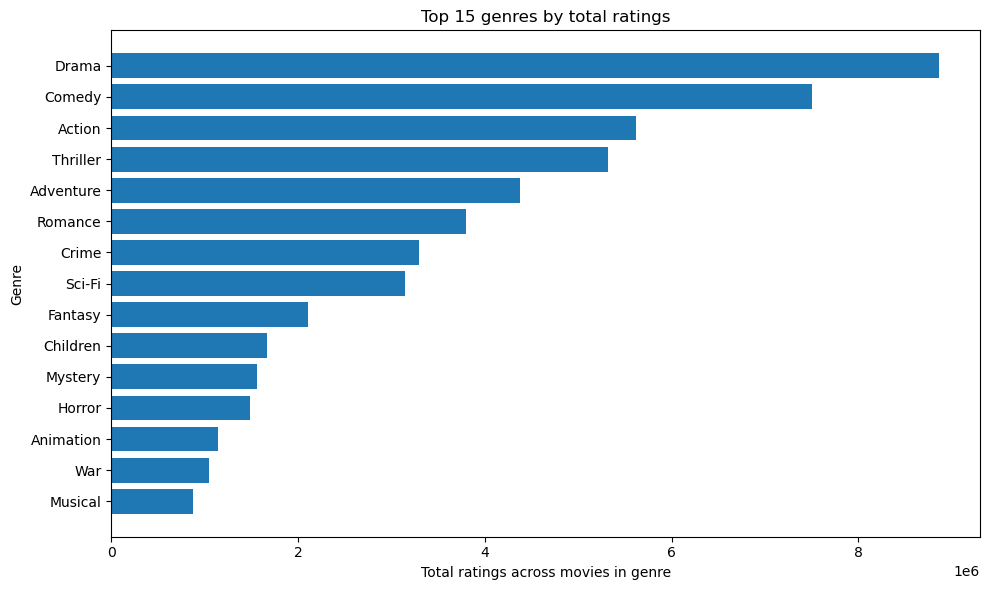

In [45]:
topN = 15
top = genre_agg.head(topN).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top.index.astype(str), top["total_ratings"].values)
plt.title(f"Top {topN} genres by total ratings")
plt.xlabel("Total ratings across movies in genre")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


## 7) Sparsity diagnostics

We estimate the sparsity of the user–item matrix:
sparsity = 1 - (#observed interactions / (#users * #movies))

We also visualize a small sampled interaction matrix (existence of a rating).


Users: 138,493
Movies (rated): 26,744
Interactions: 20,000,263
Sparsity: 0.994600


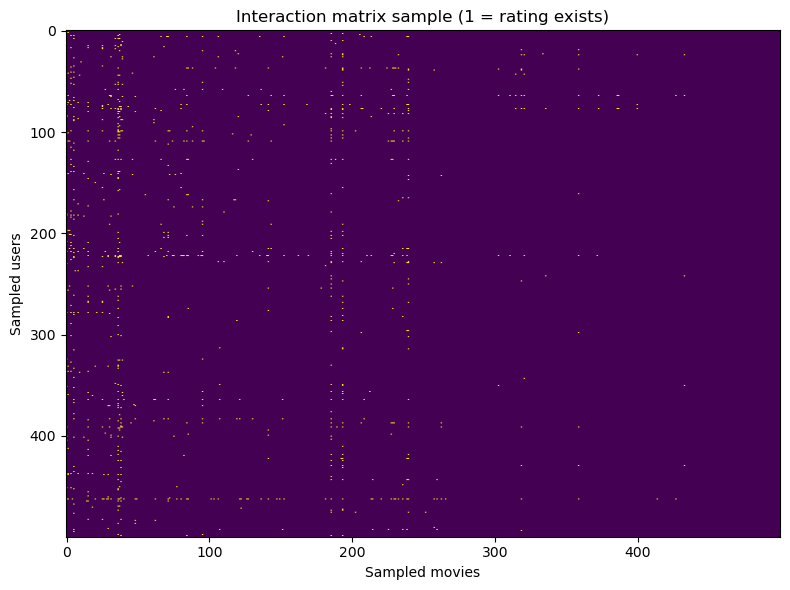

In [46]:
n_users = ratings["userId"].nunique()
n_movies = ratings["movieId"].nunique()
n_interactions = len(ratings)

sparsity = 1.0 - (n_interactions / (n_users * n_movies))
print(f"Users: {n_users:,}")
print(f"Movies (rated): {n_movies:,}")
print(f"Interactions: {n_interactions:,}")
print(f"Sparsity: {sparsity:.6f}")

SAMPLE_USERS = 500
SAMPLE_MOVIES = 500

sample_users = np.random.choice(ratings["userId"].unique(), size=min(SAMPLE_USERS, n_users), replace=False)
sample_movies = np.random.choice(ratings["movieId"].unique(), size=min(SAMPLE_MOVIES, n_movies), replace=False)

sample = ratings[ratings["userId"].isin(sample_users) & ratings["movieId"].isin(sample_movies)]

user_index = {u: i for i, u in enumerate(sorted(sample_users))}
movie_index = {m: j for j, m in enumerate(sorted(sample_movies))}
mat = np.zeros((len(sample_users), len(sample_movies)), dtype=np.uint8)

for u, m in zip(sample["userId"].values, sample["movieId"].values):
    mat[user_index[u], movie_index[m]] = 1

plt.figure(figsize=(8, 6))
plt.imshow(mat, aspect="auto")
plt.title("Interaction matrix sample (1 = rating exists)")
plt.xlabel("Sampled movies")
plt.ylabel("Sampled users")
plt.tight_layout()
plt.show()


**We can take the next conclusions:**

- Only 0.54% of all possible user–movie pairs contain a rating.
MovieLens behaves exactly like a real recommender-system environment: most users rate very few movies, and most movies receive very few ratings.

- Because users only overlap on a tiny fraction of movies, user-based similarity becomes unreliable.
Item-based KNN performs slightly better but still suffers from the lack of co-occurrence.

- Latent factor models are designed for sparse matrices.
They can extract meaningful structure even when the majority of entries are missing.

- Given the high sparsity, combining collaborative signals with content features (genres, tags, embeddings, Genome data) significantly improves: predictions, cold start handling, recommendation quality

- Due to extreme sparsity: genre–year averages, trend lines, time-series plots must filter out years/genres with insufficient data

## 8) Popularity vs. mean rating

A common diagnostic: popularity (number of ratings) vs. average rating.
To reduce noise, filter to movies with at least `MIN_RATINGS`.


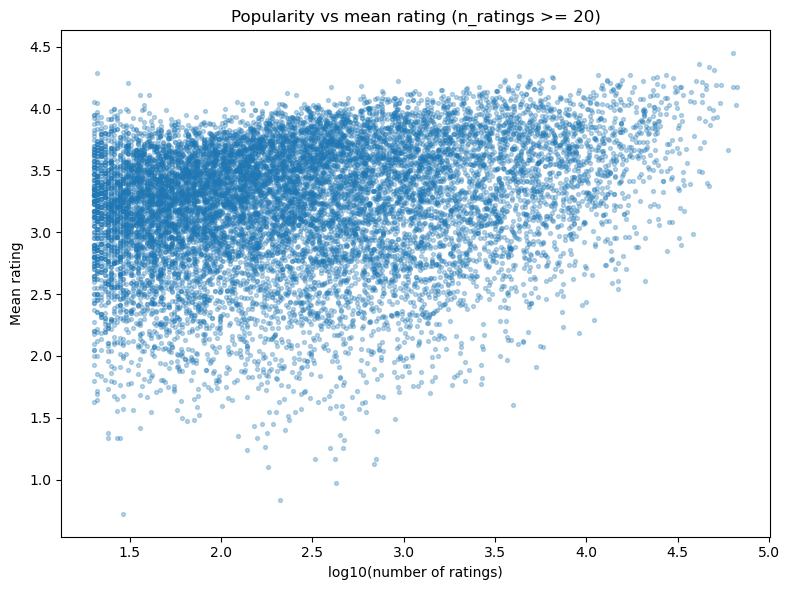

Correlation between log popularity and mean rating: 0.2391


In [47]:
MIN_RATINGS = 20
ms = movie_stats[movie_stats["n_ratings"] >= MIN_RATINGS].copy()

plt.figure(figsize=(8, 6))
plt.scatter(np.log10(ms["n_ratings"].values), ms["mean_rating"].values, s=8, alpha=0.3)
plt.title(f"Popularity vs mean rating (n_ratings >= {MIN_RATINGS})")
plt.xlabel("log10(number of ratings)")
plt.ylabel("Mean rating")
plt.tight_layout()
plt.show()

corr = np.corrcoef(np.log10(ms["n_ratings"].values), ms["mean_rating"].values)[0, 1]
print(f"Correlation between log popularity and mean rating: {corr:.4f}")


**Do we like this relation?**
Yes! We do. This means that we are avoiding some dangerous bias that people commonly have when choosing a film.

1. Selection bias. People generally choose to watch movies they expect to like → pushes averages up for popular titles.

2. Cultural consensus - Movies widely viewed often include: classics ,blockbusters, critically acclaimed films. These usually maintain mid-to-high ratings.

3. Survivorship bias in ratings. Movies that are extremely bad rarely accumulate many ratings unless they are so bad they become memes.

## 9) Temporal analysis

We convert timestamps (Unix epoch seconds) to UTC datetimes and inspect:
- rating volume over time (by year)
- average rating over time
- like-rate over time


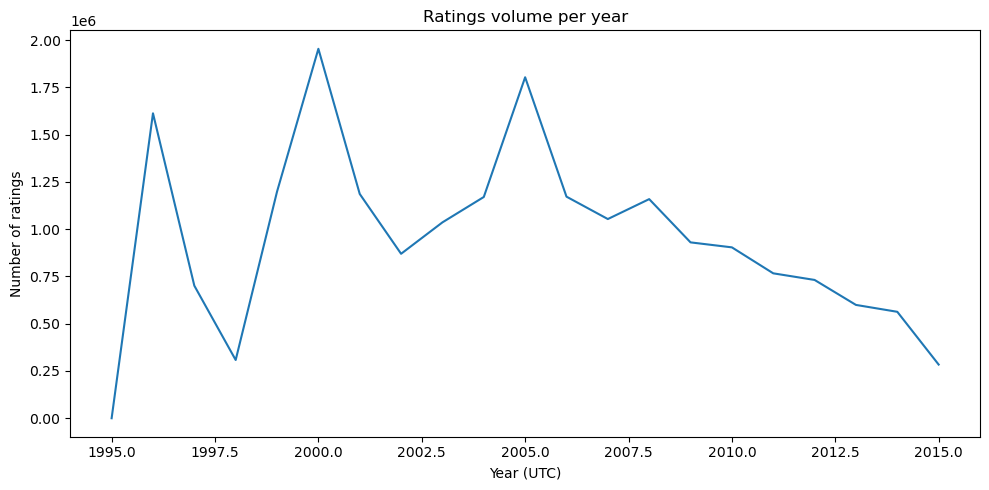

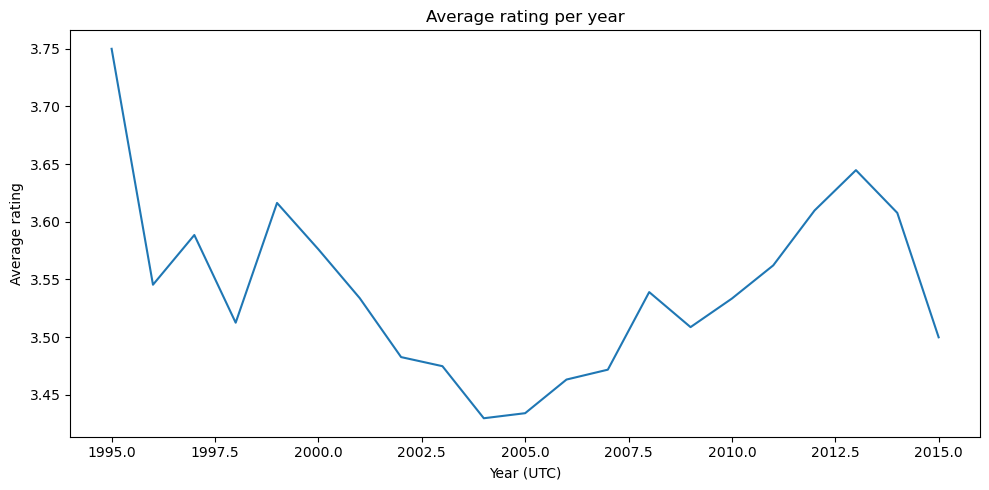

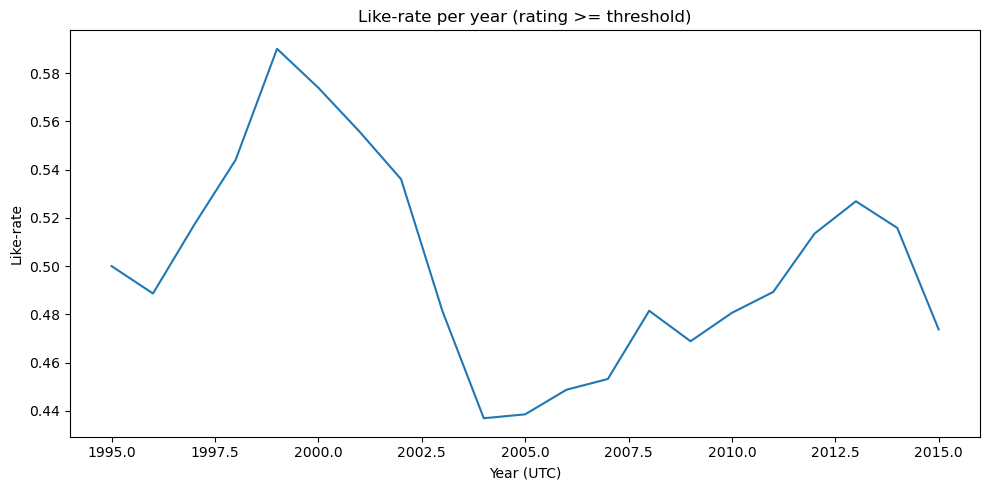

In [48]:
ratings["datetime"] = pd.to_datetime(ratings["timestamp"], unit="s", utc=True)
ratings["year"] = ratings["datetime"].dt.year

year_counts = ratings.groupby("year").size()
plt.figure(figsize=(10, 5))
plt.plot(year_counts.index.values, year_counts.values)
plt.title("Ratings volume per year")
plt.xlabel("Year (UTC)")
plt.ylabel("Number of ratings")
plt.tight_layout()
plt.show()

year_mean = ratings.groupby("year")["rating"].mean()
plt.figure(figsize=(10, 5))
plt.plot(year_mean.index.values, year_mean.values)
plt.title("Average rating per year")
plt.xlabel("Year (UTC)")
plt.ylabel("Average rating")
plt.tight_layout()
plt.show()

year_like = ratings.groupby("year")["like"].mean()
plt.figure(figsize=(10, 5))
plt.plot(year_like.index.values, year_like.values)
plt.title("Like-rate per year (rating >= threshold)")
plt.xlabel("Year (UTC)")
plt.ylabel("Like-rate")
plt.tight_layout()
plt.show()


So, me can see a decline in the amount of reviews. this could be due to the decline of the use of the platforms, and the rise of the in demand platforms. Tehre is an interesting turn in 2007.

This oblige us to be extreme careful when it comes to calculate cronological data. We have to avoid leakage

## 10) User tags exploration (`tag.csv`)

User tags can be used as sparse content features or for exploratory semantics.
We inspect:
- number of tag assignments
- unique tags
- coverage among rated movies
- top tags by frequency
- tag length / basic cleaning checks


In [49]:
print("Tag assignments:", len(tags))
print("Unique tags:", tags["tag"].nunique())
print("Movies with tags:", tags["movieId"].nunique())
print("Users who tag:", tags["userId"].nunique())

movies_with_tags = set(tags["movieId"].unique())
rated_movies = set(ratings["movieId"].unique())
coverage = len(movies_with_tags & rated_movies) / len(rated_movies)
print(f"Tag coverage among rated movies: {coverage:.3%}")

tags["tag"] = tags["tag"].astype("string")
tags["tag_len"] = tags["tag"].str.len()
print("\nTag length summary:")
print(tags["tag_len"].describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

top_tags = tags["tag"].value_counts().head(30)
top_tags


Tag assignments: 465564
Unique tags: 38643
Movies with tags: 19545
Users who tag: 7801
Tag coverage among rated movies: 71.085%

Tag length summary:
count     465548.0
mean     11.068599
std       6.117719
min            1.0
50%           10.0
90%           17.0
95%           21.0
99%           31.0
max          241.0
Name: tag_len, dtype: Float64


tag
sci-fi                3384
based on a book       3281
atmospheric           2917
comedy                2779
action                2657
surreal               2427
BD-R                  2334
twist ending          2323
funny                 2072
dystopia              1991
stylized              1941
quirky                1906
dark comedy           1899
classic               1769
psychology            1754
fantasy               1703
time travel           1549
romance               1534
visually appealing    1509
disturbing            1487
aliens                1428
thought-provoking     1422
social commentary     1417
Nudity (Topless)      1400
violence              1336
drugs                 1312
Criterion             1286
true story            1276
nudity (topless)      1245
adventure             1243
Name: count, dtype: int64[pyarrow]

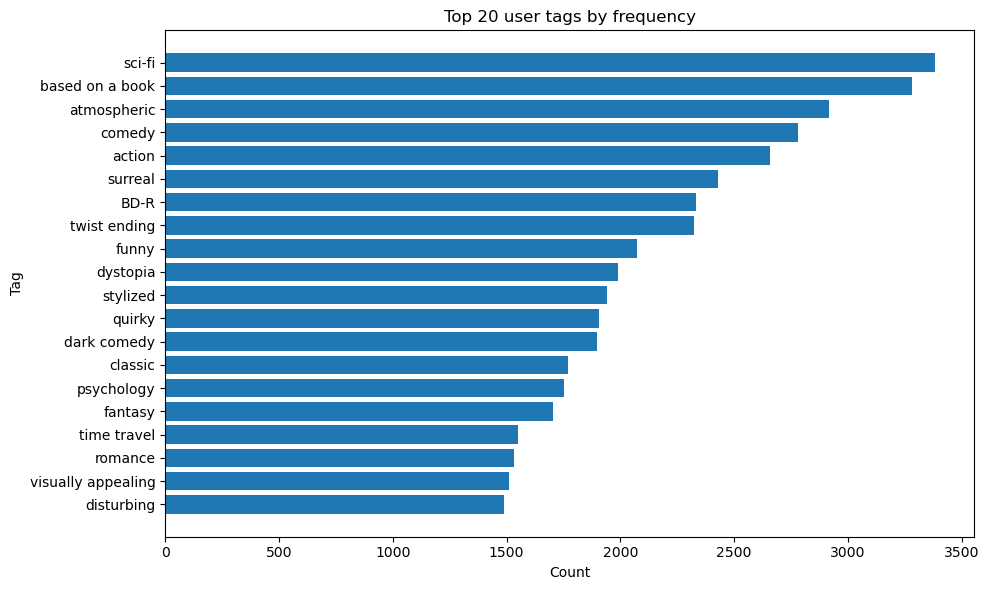

In [50]:
topN = 20
top = tags["tag"].value_counts().head(topN).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(top.index.astype(str), top.values)
plt.title(f"Top {topN} user tags by frequency")
plt.xlabel("Count")
plt.ylabel("Tag")
plt.tight_layout()
plt.show()


## 11) Genome features exploration (`genome_scores.csv`, `genome_tags.csv`)

Genome features provide a standardized tag vocabulary with real-valued relevance scores per movie.
We inspect:
- distribution of relevance scores
- coverage and completeness
- top genome tags by prevalence above a threshold
- example: retrieve the top genome tags for a popular movie


Genome merged shape: (11709768, 4)
Missing genome tag labels: 0


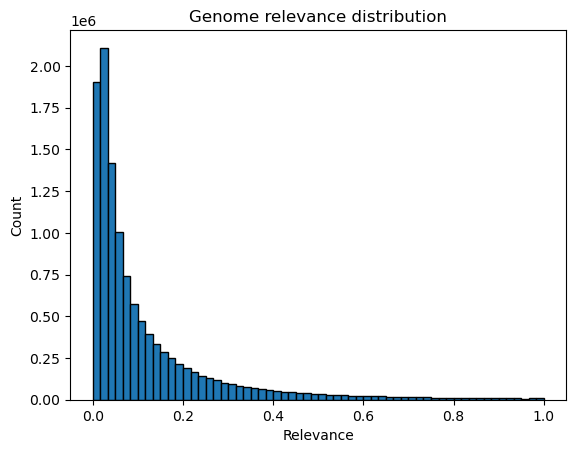

count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
50%      5.650000e-02
90%      2.980000e-01
95%      4.452500e-01
99%      7.792500e-01
max      1.000000e+00
Name: relevance, dtype: float64

In [51]:
genome = genome_scores.merge(genome_tags, on="tagId", how="left")

print("Genome merged shape:", genome.shape)
print("Missing genome tag labels:", int(genome["tag"].isna().sum()))

plt.figure()
plt.hist(genome["relevance"].values, bins=60, edgecolor="black")
plt.title("Genome relevance distribution")
plt.xlabel("Relevance")
plt.ylabel("Count")
plt.show()

genome["relevance"].describe(percentiles=[0.5, 0.9, 0.95, 0.99])


- Most relevance scores are very low (median ≈ 0.056, mean ≈ 0.116).
- Only a small subset of tags per movie carries meaningful semantic information.
- The Genome matrix is dense in structure but semantically sparse.
- High-relevance tags capture strong content attributes (themes, tone, style).

**Implications**
- Avoid using all 1,100 raw tag relevance values as features (too much noise).
- Prefer approaches such as:
  - Top-N most relevant tags per movie
  - Threshold filtering (keep only tags above a relevance cutoff)
  - Dimensionality reduction (e.g., PCA/SVD embeddings)
- Genome features strongly improve hybrid recommenders and cold-start performance.

Genome tags provide rich semantic information, but only a small portion of them is useful for each movie.  
Focus on extracting the most relevant tags or building reduced embeddings rather than using the full raw matrix.


In [52]:
tags_per_movie = genome.groupby("movieId")["tagId"].nunique()
print("Genome tags per movie summary:")
print(tags_per_movie.describe(percentiles=[0.5, 0.9, 0.95, 0.99]))

n_tagids = genome_tags["tagId"].nunique()
print("Genome tag vocabulary size (tagId):", n_tagids)

full_vec_movies = (tags_per_movie == n_tagids).mean()
print(f"Fraction of genome movies with full tagId coverage: {full_vec_movies:.3%}")


Genome tags per movie summary:
count    10381.0
mean      1128.0
std          0.0
min       1128.0
50%       1128.0
90%       1128.0
95%       1128.0
99%       1128.0
max       1128.0
Name: tagId, dtype: float64
Genome tag vocabulary size (tagId): 1128
Fraction of genome movies with full tagId coverage: 100.000%


In [53]:
RELEVANCE_THRESHOLD = 0.7

tag_agg = (
    genome.groupby(["tagId", "tag"])
    .agg(
        n_movies=("movieId", "nunique"),
        mean_relevance=("relevance", "mean"),
        p_above_thr=("relevance", lambda x: float((x >= RELEVANCE_THRESHOLD).mean())),
    )
    .reset_index()
)

tag_agg.sort_values("p_above_thr", ascending=False).head(25)


,tagId,tag,n_movies,mean_relevance,p_above_thr
741,742,original,10381,0.730528,0.614777
645,646,mentor,10381,0.530233,0.149793
269,270,criterion,10381,0.388207,0.138233
229,230,comedy,10381,0.250628,0.133032
322,323,drama,10381,0.361095,0.119064
971,972,storytelling,10381,0.448479,0.113284
451,452,good soundtrack,10381,0.455614,0.110587
18,19,action,10381,0.265466,0.106637
845,846,relationships,10381,0.282563,0.105096
1103,1104,weird,10381,0.361088,0.103458


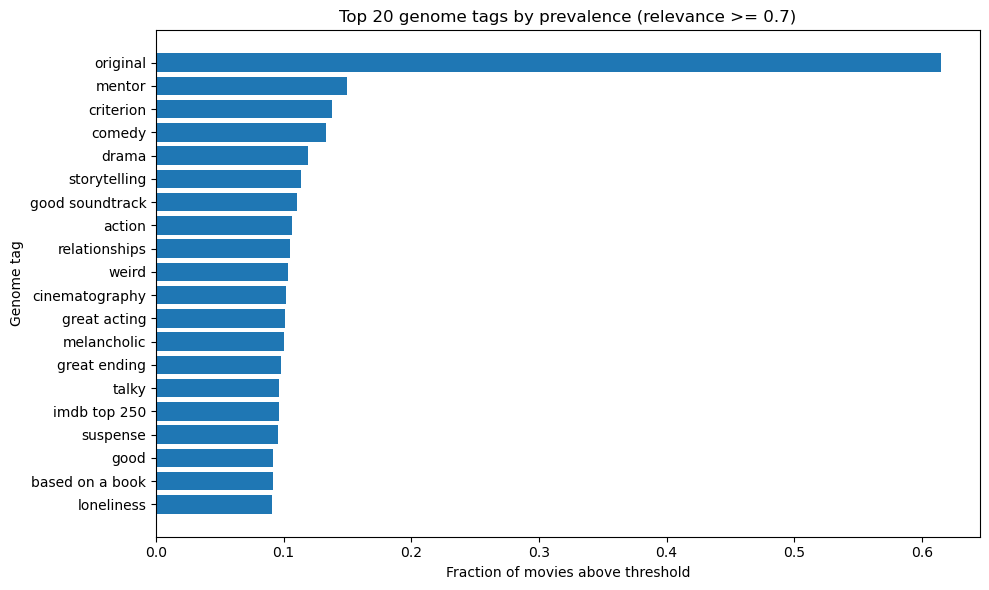

In [54]:
topN = 20
t = tag_agg.sort_values("p_above_thr", ascending=False).head(topN).iloc[::-1]

plt.figure(figsize=(10, 6))
plt.barh(t["tag"].astype(str), t["p_above_thr"].values)
plt.title(f"Top {topN} genome tags by prevalence (relevance >= {RELEVANCE_THRESHOLD})")
plt.xlabel("Fraction of movies above threshold")
plt.ylabel("Genome tag")
plt.tight_layout()
plt.show()


In [55]:
# Example: top genome tags for a popular movie
popular_movie_id = int(movie_stats.sort_values("n_ratings", ascending=False).iloc[0]["movieId"])
movie_title = movies.loc[movies["movieId"] == popular_movie_id, "title"].iloc[0]
print("Example movieId:", popular_movie_id)
print("Title:", movie_title)

top_movie_tags = genome[genome["movieId"] == popular_movie_id].sort_values("relevance", ascending=False).head(20)
top_movie_tags[["tagId", "tag", "relevance"]]


Example movieId: 296
Title: Pulp Fiction (1994)


,tagId,tag,relevance
316349,510,hit men,0.99950
316302,463,gratuitous violence,0.99050
316128,289,dark humor,0.98575
316473,634,masterpiece,0.98250
316375,536,imdb top 250,0.98050
316553,714,non-linear,0.97875
316262,423,gangster,0.97850
316923,1084,violence,0.97575
316924,1085,violent,0.97500
316263,424,gangsters,0.97350


## 12) Links coverage (`link.csv`)

`link.csv` can be useful for enrichment (posters, plot summaries, cast, etc.) if you later join with external sources.
We check missing rates and coverage for rated movies.


In [56]:
print("Links rows:", len(links))
print("Missing imdbId:", int(links["imdbId"].isna().sum()))
print("Missing tmdbId:", int(links["tmdbId"].isna().sum()))

rated_movies = set(ratings["movieId"].unique())
links_movies = set(links["movieId"].unique())
print(f"Link coverage among rated movies: {len(rated_movies & links_movies)/len(rated_movies):.3%}")

links.sample(5, random_state=RANDOM_SEED)


Links rows: 27278
Missing imdbId: 0
Missing tmdbId: 252
Link coverage among rated movies: 100.000%


,movieId,imdbId,tmdbId
12922,61116,69792,22029
14085,70697,436339,19585
23517,111931,2111392,174682
8960,26630,95655,13192
13152,63692,15758,111759


## 13) Cleaning checks and outlier patterns

We check:
- duplicates in (userId, movieId)
- cold-start prevalence for users and movies
- users with degenerate rating behavior (constant ratings)


In [59]:
dup_count = ratings.duplicated(subset=["userId", "movieId"]).sum()
print("Duplicate (userId, movieId) rows:", int(dup_count))

MOVIE_MIN_RATINGS = 20
USER_MIN_RATINGS = 30

frac_cold_movies = (movie_stats["n_ratings"] < MOVIE_MIN_RATINGS).mean()
frac_cold_users  = (user_stats["n_ratings"] < USER_MIN_RATINGS).mean()

print(f"Movies with < {MOVIE_MIN_RATINGS} ratings: {frac_cold_movies:.3%}")
print(f"Users with < {USER_MIN_RATINGS} ratings: {frac_cold_users:.3%}")

user_range = ratings.groupby("userId")["rating"].agg(lambda x: float(x.max() - x.min())).rename("rating_range")
print("Users with rating range == 0 (constant ratings):", int((user_range == 0).sum()))
user_range.describe(percentiles=[0.5, 0.9, 0.95, 0.99])


Duplicate (userId, movieId) rows: 0
Movies with < 20 ratings: 50.897%
Users with < 30 ratings: 18.733%
Users with rating range == 0 (constant ratings): 90


count    138493.000000
mean          3.731665
std           0.741423
min           0.000000
50%           4.000000
90%           4.500000
95%           4.500000
99%           4.500000
max           4.500000
Name: rating_range, dtype: float64